# Summary

This notebook demonstrates an implementation of Deep Double Q-Learning (DDQN), a reinforcement learning algorithm designed to mitigate overestimation bias while efficiently solving complex decision-making problems. Specifically, this notebook applies DDQN to an energy-constrained path planning problem, where an agent (e.g., a robot) learns to navigate a grid-based environment, reaching the goal state efficiently while optimizing energy consumption and utilizing charging stations to recharge its battery.

This code is adapted from the [PyTorch tutorial on training a mario-playing RL agent](https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html).

# Installing Required Packages

In [ ]:
# For hardware acceleration
%pip install torch torchvision torchaudio

# For plotting
%pip install matplotlib

# Import Modules

In [1]:
import numpy as np
import os
import random
import torch
from collections import deque
from copy import deepcopy

# Global Variables

In [2]:
# Set computational hardware
DEVICE = 'cuda'

# Helper Classes/Methods

In [3]:
class dicta(dict):
    '''
    A subclass of the built-in `dict` that allows attribute-style access to dictionary keys.
    
    Methods:
        __getattr__(key): Get a value using dot notation (e.g., obj.key instead of obj['key']).
        __setattr__(key, value): Set a value using dot notation (e.g., obj.key = value instead of obj['key'] = value)
        __delattr__(key): Delete a key using dot notation (e.g., del obj.key instead of del obj['key'])
    '''
    
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [4]:
class ProgressBar:
    '''
    A simple command-line progress bar for tracking task completion.

    Attributes:
        total (int): The total number of steps or tasks to complete.
        ncols (int): The width of the progress bar in characters.
        count (int): The current progress count.
        num_digits (int): The number of digits in the total count, used for formatting.
    '''

    def __init__(self, total: int, ncols: int = 50) -> None:
        '''
        Initializes the progress bar.

        Args:
            total (int): Total number of steps or tasks to complete.
            ncols (int, optional): Width of the progress bar. Default is 50 characters.
        '''
        
        # Initialize the current progress count
        self.count = 0

        # Set the total steps
        self.total = total

        # Set the width of the progress bar
        self.ncols = ncols

        # Calculate the number of digits in the number total for formatting purposes
        self.num_digits = len(str(self.total))

        # Display the initial empty progress bar
        self.print()

    def print(self) -> None:
        ''' Displays the progress bar in the command line. The bar dynamically adjusts based on the current progress count.'''
        
        # Calculate the completion ratio
        completion_ratio = self.count / self.total
        
        # Generate the filled portion of the bar
        bar = '=' * int(completion_ratio * self.ncols)

        # Add a head to the bar and pad it to full width
        bar = f'{bar}>'.ljust(self.ncols + 1)
        
        # Convert completion ratio from decimal to percentage format for printing
        percentage = int(completion_ratio * 100)

        # Print the progress bar with the current count and total
        print(
            f'\r[{bar}]  {self.count:>{self.num_digits}} / {self.total}  [{percentage:3}%]',
            end = '\n' if self.count == self.total else '',  # Move to a new line if complete
            flush = True  # Ensure the output is immediately visible
        )

    def step(self, size: int = 1) -> None:
        '''
        Advances the progress bar by a specified number of steps.

        Args:
            size (int, optional): Number of steps to advance the progress bar. Default is 1.
        '''
        
        # Increment the current progress count by the given size
        self.count += size

        # Ensure the count does not exceed the total
        self.count = min(self.count, self.total)

        # Update the displayed progress bar
        self.print()

# Environment

In [5]:
class Environment:
    '''
    Represents a grid-based environment for an agent (i.e., robot) to navigate.
    
    Attributes:
        shape (tuple[int, int]): Dimensions of the grid (rows, cols).
        starting_state (tuple[int, int]): Initial position of the agent in the grid.
        goal_state (tuple[int, int]): Target position the agent must reach.
        charging_station_states (list[tuple[int, int]]): Positions of charging stations in the grid.
        num_channels (int): Number of channels in the environment's state representation.
        state_dim (tuple[int, int, int]): Dimensions of the state representation as (channels, rows, cols).
        max_episode_length (int): Maximum number of steps in an episode.
        action_names (list[str]): List of possible actions ('U', 'UR', 'R', etc.).
        action_dim (int): Number of possible actions.
        curr_state (np.ndarray): Current position of the agent as a NumPy array.
        path (list[tuple[int, int]]): Path taken by the agent in the current episode.
        reward (float): Cumulative reward earned by the agent in the current episode.
        channels (dicta): A dictionary-like object containing the grid's channel data.
    '''
    
    def __init__( self,
        shape: tuple[int, int],
        starting_state: tuple[int, int],
        goal_state: tuple[int, int],
        charging_station_states: list[tuple[int, int]],
    ) -> None:
        '''
        Initializes the environment.

        Args:
            shape (tuple[int, int]): Dimensions of the grid (rows, cols).
            starting_state (tuple[int, int]): Initial position of the agent.
            goal_state (tuple[int, int]): Target position the agent must reach.
            charging_station_states (list[tuple[int, int]]): Positions of charging stations in the grid.
        '''
        
        # Store arguments
        self.shape = shape
        self.starting_state = starting_state
        self.goal_state = goal_state
        self.charging_station_states = charging_station_states
        
        # Set the number of state channels
        # Channels to represent goal, charging stations, coverage, and agent position
        self.num_channels = 4
        
        # Calculate state dimensions
        self.state_dim = (self.num_channels, *self.shape)
        
        # Limit number of steps to the grid size
        self.max_episode_length = self.shape[0] * self.shape[1]
        
        # Define all possible actions
        self.action_names = ['U', 'UR', 'R', 'DR', 'D', 'DL', 'L', 'UL']
        self.action_dim = len(self.action_names)
        
        # Create grid channels for environment states
        self.create_channels()
        
        # Initialize the agent's position and episode related variables
        self.curr_state = np.array(self.starting_state, dtype = np.float32)
        self.path = [self.starting_state]
        self.reward = 0.0
    
    def create_channels(self) -> None:
        '''
        Creates the grid channels, excluding the agent's current position, for the environment. The channel marking the agent's position will be generated upon request and will not be stored, as it is always changing.
        
        The channels include:
            - Goal: Marks the goal position.
            - Charging Stations: Marks the position of the charging stations.
            - Coverage: Tracks grid cells visited by the agent.
            - Agent Position: Marks the current position of the agent.
        '''
        
        # Dictionary to store the channels
        self.channels = dicta()
        
        # Create a channel to mark the goal position
        self.channels.goal = np.zeros(self.shape, dtype = np.float32)
        x, y = self.goal_state
        self.channels.goal[x][y] = 1.0
        
        # Create a channel to mark the positions of the charging stations
        self.channels.charging_station_states = np.zeros(self.shape, dtype = np.float32)
        for x, y in self.charging_station_states:
            self.channels.charging_station_states[x][y] = 1.0
        
        # Create a channel to track the grid cells visited by the agent
        self.channels.coverage = np.zeros(self.shape, dtype = np.float32)
    
    def transition(self, action: int) -> np.ndarray:
        '''
        Calculates the next state based on the given action.
        
        Args:
            action (int): Index of the action to perform.
        
        Returns:
            np.ndarray: The resulting state after executing the action.
        '''
        
        # Get the action's name
        action_name = self.action_names[action]
        
        # Calculate the new position given the action
        next_state = np.copy(self.curr_state)
        if 'U' in action_name:
            next_state[0] += 1
        elif 'D' in action_name:
            next_state[0] -= 1
        if 'R' in action_name:
            next_state[1] += 1
        elif 'L' in action_name:
            next_state[1] -= 1
        
        # Validate the new position; if invalid, stay in the current state
        if all([0 <= v < self.shape[i] for i, v in enumerate(next_state)]):
            return next_state
        return self.curr_state
    
    def get_reward(self, next_state: np.ndarray, eta: int, info: dict) -> float:
        '''
        Calculates the reward for the agent's choice of action.
        
        Args:
            next_state (np.ndarray): The agent's next state.
            eta (int): Remaining energy budget.
            info (dict):
                reached_goal (bool): Whether the agent has reached the goal state
                reached_charging_station (bool): Whether the agent has reached a charging station.
        
        Returns:
            float: The reward for the agent's choice of action.
        '''
        
        # Reward the agent for reaching the goal
        if info.reached_goal:
            self.reward += 200
            return 200
        
        x, y = next_state.astype(int)
        reward = []
        
        # Penalize for not reaching a charging station before running out of energy
        reward.append(-2.0 if eta < 0 else 0.05)
        
        # Penalize for revisiting cells
        if int(self.channels.coverage[x][y]):
            reward.append(-2.0)
        
        # Reward progress toward the goal
        curr_dis = np.linalg.norm(self.goal_state - self.curr_state)
        next_dis = np.linalg.norm(self.goal_state - next_state)
        reward.append(curr_dis - next_dis)
        
        # Add step penalty
        reward.append(-0.05)
        
        # Average rewards and update cumulative reward
        reward = np.mean(reward)
        self.reward += reward
        return reward
    
    def add_coverage(self, state: np.ndarray) -> None:
        '''
        Updates the coverage channel and records the agent's path.

        Args:
            state (np.ndarray): The current state of the agent.
        '''
        
        # Update the coverage channel
        x, y = state.astype(int)
        self.channels.coverage[x][y] = 1.0
        
        # Append the path
        self.path.append(tuple(state))
    
    def step(self, action: int, eta: int) -> tuple[torch.Tensor, float, bool, dict]:
        '''
        Simulates a single step in the environment based on the given action.
        
        Args:
            action (int): Index of the action to execute.
            eta (int): Remaining energy budget.
        
        Returns:
            Tensor: State channels after executing the action.
            float: Reward for the action.
            bool: Whether the episode is terminated.
            dict: Information about whether the goal or a charging station is reached.
        '''
        
        # Get next state
        next_state = self.transition(action)
        
        # Check if reached the goal state
        reached_goal = all(next_state == self.goal_state)
        
        # Check if reached a charging station
        reached_charging_station = any(np.all(next_state == self.charging_station_states, axis = 1))
        
        # Check if reached a terminal state
        is_done = reached_goal or eta < 1 or (len(self.path) >= self.max_episode_length)
        
        # Compute reward
        info = dicta(
            reached_goal = reached_goal,
            reached_charging_station = reached_charging_station
        )
        reward = self.get_reward(next_state, eta, info)
        
        # Update the agent's position
        self.add_coverage(next_state)
        self.curr_state = next_state
        
        return self(), reward, is_done, info
    
    def reset(self) -> tuple[list[tuple[int, int]], float]:
        '''
        Resets the environment to prepare for the next episode.
        
        Returns:
            list[tuple[int, int]]: The path taken by the agent in the terminated episode.
            float: Cumulative reward from the terminated episode.
        '''
        
        # Capture the path and reward before performing the reset
        path, reward = self.path[:], self.reward
        # Reset episode-related channels and variables
        self.channels.coverage = np.zeros(self.shape, dtype = np.float32)
        self.curr_state = np.array(self.starting_state, dtype = np.float32)
        self.path = [self.starting_state]
        self.reward = 0.0
        
        # Return the path and reward from the terminated episode
        return path, reward
    
    def __call__(self) -> torch.Tensor:
        '''
        Returns the current state channels as a tensor.

        Returns:
            Tensor: Tensor representation of the environment's current state.
        '''
        
        # Create the agent position channel
        agent_position = np.zeros(self.shape, dtype = np.float32)
        x, y = self.curr_state.astype(int)
        agent_position[x][y] = 1.0
        
        # Combine all channels into a single tensor
        return torch.from_numpy(np.array([
            self.channels.goal,
            self.channels.charging_station_states,
            agent_position,
            self.channels.coverage
        ], dtype = np.float32))

# Neural Networks

In [6]:
class AppendRemainingBudget(torch.nn.Module):
    '''
    A custom PyTorch layer that appends the agent's remaining energy budget (eta) as an additional input to the neural network.

    Attributes:
        robot (Robot): The agent whose energy budget is being appended.
    '''
    
    def __init__(self, robot: 'Robot') -> None:
        '''
        Initializes the layer with a reference to the agent (i.e., robot).

        Args:
            robot (Robot): The agent whose energy budget will be appended.
        '''
        
        super().__init__()
        self.robot = robot
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        Adds the agent's remaining energy budget (eta) to the input tensor.

        Args:
            x (Tensor): The input tensor to the neural network.

        Returns:
            Tensor: The augmented input tensor after appending the remaining budget.
        '''
        
        # Create a tensor filled with the current remaining budget (eta)
        eta = (torch.zeros((x.shape[0], 1), dtype = torch.float32) + self.robot.eta).to(DEVICE)
        
        # Concatenate the budget tensor to the input tensor along the last dimension
        return torch.cat((x, eta), dim = -1)

class Net(torch.nn.Module):
    '''
    Represents the deep neural network used for the agent's Q-value approximation. This class defines both the online and target networks used in Deep Double Q-Learning.

    Attributes:
        online (torch.nn.Sequential): The online Q-network used for action selection and updates.
        target (torch.nn.Sequential): The target Q-network used for stabilizing training.
    '''
    
    def __init__(self, input_dim: tuple[int, int, int], output_dim: int, robot: 'Robot') -> None:
        '''
        Initializes the network with the required layers and configurations.

        Args:
            input_dim (tuple[int, int, int]): Dimensions of the input state space (channels, height, width).
            output_dim (int): Number of possible actions (i.e., size of the action space).
            robot (Robot): The agent, used for appending remaining budget in the network.
        '''
        
        # Initilize the neural network module
        super().__init__()
        
        # Unpack the input dimensions
        c, h, w = input_dim
        
        # Define the online network
        self.online = torch.nn.Sequential(
            # First convolutional layer
            torch.nn.Conv2d(c, 8, kernel_size = 5, stride = 1, padding = 2, device = DEVICE),
            torch.nn.ReLU(),
            
            # Second convolutional layer
            torch.nn.Conv2d(8, 16, kernel_size = 5, stride = 1, padding = 2, device = DEVICE),
            torch.nn.ReLU(),
            
            # Flatten the feature map
            torch.nn.Flatten(),
            
            # Append the agent's remaining budget
            AppendRemainingBudget(robot = robot),
            
            # Fully connected layers
            torch.nn.Linear(16*h*w + 1, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, output_dim)
        )
        
        # Create a copy of the online network for the target network
        self.target = deepcopy(self.online)
        
        # The target network has its own new agent due to copying the network.
        # Override the reference of the agent to the original instance in the target network.
        self.target[5].robot = robot
        
        # Get networks to the specified device
        if DEVICE != 'cpu':
            self.online = self.online.to(DEVICE)
            self.target = self.target.to(DEVICE)
        
        # Freeze the parameters of the target network to prevent updates
        for parameter in self.target.parameters():
            parameter.requires_grad = False
    
    def forward(self, x: torch.Tensor, model: str) -> torch.Tensor:
        '''
        Performs a forward pass through the specified Q-network (online or target).

        Args:
            x (Tensor): Input tensor representing the state.
            model (str): Specifies which network to use ('online' or 'target').

        Returns:
            Tensor: Q-values for all possible actions.
        '''
        
        # Retrieve the specified model (online or target) and perform a forward pass
        return getattr(self, model)(x.to(DEVICE))

# Agent

In [7]:
class Robot:
    '''
    Represents an agent that interacts with the environment using Deep Double Q-Learning (DDQN). Check the constructor for the list of attributes.
    
    Attributes:
        step (int): Cumulative number of steps taken by the agent
        eta (int): Remaining energy
        epsilon (float): Current exploration rate.
        epsilon_no_decay_episodes (int): Number of episodes with no epsilon decay. On the next episode, the agent has completed the warmup steps and epsilon started decaying.
        net (Net): Neural networks for Q-learning
        memory (deque): replay memory to store experiences
        loss_fn (torch.Tensor): The loss function
        optimizer (torch.optim.Optimizer): The optimizer
    '''
    
    def __init__( self,
        state_dim: tuple[int, int, int],
        action_dim: int,
        budget: float,
        cost_per_step: float = 1.0,
        episode: int = 0,
        energy_free_episodes: int = 0,
        gamma: float = 1.0,
        learning_rate: float = 5e-4,
        epsilon_init: float = 1.0,
        epsilon_warmup_steps: int = 0,
        epsilon_decay_rate: float = 1e-5,
        epsilon_decay_episodes: int = None,
        epsilon_min: float = 0.05,
        memory_size: int = 10000,
        batch_size: int = 32,
        learn_steps: int = 2000,
        sync_strategy: str = 'step',
        sync_frequency: int = 5000,
        checkpoint_dir: str = None,
        checkpoint_strategy: str = 'step',
        checkpoint_frequency: int = 5000
    ) -> None:
        '''
        Initializes the robot with hyperparameters, exploration policy, and neural networks.

        Args:
            state_dim (tuple[int, int, int]): Dimensions of the state space (channels, height, width).
            action_dim (int): Size of the action space.
            budget (float): Battery capacity.
            cost_per_step (float): Energy cost for taking an action.
            episode (int): Starting episode number.
            energy_free_episodes (int): The number of episodes before the cost per step is enabled. I.e., during these episodes the battery will not discharge due to no cost per step.
            gamma (float): Discount factor for future rewards.
            learning_rate (float): Learning rate for training the neural network.
            epsilon_init (float): Initial exploration rate for epsilon-greedy policy.
            epsilon_warmup_steps (int): Number of steps before epsilon starts decaying.
            epsilon_decay_rate (float): Exponential rate at which epsilon decays during training. Rate will be recalculated if `epsilon_decay_episodes` is provided.
            epsilon_decay_episodes (int, optional): Number of episodes over which epsilon fully decays.
            epsilon_min (float): Minimum exploration rate.
            memory_size (int): Maximum size of the experience replay buffer.
            batch_size (int): Number of samples per training batch.
            learn_steps (int): Number of steps between Q-network updates.
            sync_strategy (str): Synchronization strategy for target and online networks ('step' or 'episode').
            sync_frequency (int): Number of steps/episodes before syncing the networks.
            checkpoint_dir (str, optional): Directory for saving model checkpoints.
            checkpoint_strategy (str): Strategy for saving checkpoints ('step' or 'episode').
            checkpoint_frequency (int): Number of steps/episodes before and in between checkpoints.
        '''
        
        # Save the arguments dynamically
        for k, v in locals().items():
            if k not in ['self', 'args', 'kwargs']:
                setattr(self, k, v)
        
        # Validate checkpoint directory, if provided.
        if self.checkpoint_dir and not os.path.isdir(self.checkpoint_dir):
            raise ValueError(f'Path provided for creating checkpoints does not exist: {self.checkpoint_dir}')
        
        # Initialize epsilon exploration rate
        self.epsilon = self.epsilon_init
        
        # Calculate epsilon decay rate if the number of episodes to reach the minimum rate is specified
        if epsilon_decay_episodes:
            self.epsilon_decay_rate = -np.log(self.epsilon_min / self.epsilon_init) / self.epsilon_decay_episodes
            print(f'Epsilon Decay Rate: {self.epsilon_decay_rate:.3E}')
        
        # Create Neural networks for Q-learning (online and target)
        self.net = Net(self.state_dim, self.action_dim, self)
        
        # Create replay memory to store experiences
        self.memory = deque(maxlen = self.memory_size)
        
        # Initialize a counter for the cumulative number of steps taken by the agent
        self.step = 0
        
        # Set the remaining energy
        self.eta = self.budget
        
        # Set up the loss function and optimizer
        self.loss_fn = torch.nn.SmoothL1Loss()
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr = self.learning_rate)
    
    def act(self, state: torch.Tensor) -> tuple[int, float]:
        '''
        Selects an action based on the epsilon-greedy policy.
        
        Args:
            state (Tensor): The current state of the agent.
        
        Returns:
            int: Index of the selected action
            float: Remaining energy after taking the action
        '''
        
        if np.random.rand() < self.epsilon:
            # Explore with a probability of epsilon
            action_idx = np.random.randint(self.action_dim)
        else:
            # Exploit by selecting the action with the highest Q-value
            state = state.to(device = DEVICE, dtype = torch.float).unsqueeze(0)
            action_values = self.net(state, model = "online")
            action_idx = torch.argmax(action_values, axis = 1).item()
        
        # Deduct energy cost for the step
        if self.episode >= self.energy_free_episodes:
            self.eta -= self.cost_per_step
        
        # Increment the step counter
        self.step += 1
        
        # Decay epsilon (i.e., the exploration rate), if warmup is complete.
        if self.step == self.epsilon_warmup_steps:
            self.epsilon_no_decay_episodes = self.episode
            self.decay_epsilon()
        
        return action_idx, self.eta
    
    def recharge(self) -> None:
        ''' Resets the remaining energy to battery capacity.'''
        
        self.eta = self.budget
    
    def decay_epsilon(self) -> None:
        ''' Decays the exploration rate exponentially.'''
        
        self.epsilon = max(
            self.epsilon_min,
            self.epsilon_init * np.exp(-self.epsilon_decay_rate * (self.episode + 1 - self.epsilon_no_decay_episodes))
        )
    
    def cache(self, state: torch.Tensor, next_state: torch.Tensor, action: int, reward: float, done: bool) -> None:
        '''
        Stores the agent's experience in the replay memory.

        Args:
            state (Tensor): Current state.
            next_state (Tensor): Resulting state after taking an action.
            action (int): Action performed.
            reward (float): Reward obtained.
            done (bool): Whether the episode is terminated.
        '''
        
        state = state.detach().clone()
        action = torch.tensor([action], device = DEVICE)
        next_state = next_state.detach().clone()
        reward = torch.tensor([reward], device = DEVICE)
        done = torch.tensor([done], device = DEVICE)
        
        self.memory.append((state, action, next_state, reward, done))

    def recall(self) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        '''
        Samples a batch of experiences at random from the replay memory.

        Returns:
            tuple[Tensor, Tensor, Tensor, Tensor, Tensor]: Batch of sampled experiences.
        '''
        
        batch = random.sample(self.memory, self.batch_size)
        state, action, next_state, reward, done = map(torch.stack, zip(*batch))
        return state, action.squeeze(), next_state, reward.squeeze(), done.squeeze()
    
    def td_estimate(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        '''
        Computes the temporal difference estimate for the current state-action pair.

        Args:
            state (Tensor): Batch of current states.
            action (Tensor): Batch of actions taken.

        Returns:
            Tensor: Estimated Q-values for the given state-action pairs.
        '''
        
        return self.net(state, model = "online")[np.arange(0, self.batch_size), action]

    @torch.no_grad()
    def td_target(self, reward: torch.Tensor, next_state: torch.Tensor, done: torch.Tensor) -> torch.Tensor:
        '''
        Computes the target Q-value using Double Q-Learning.

        Args:
            reward (Tensor): Batch of rewards.
            next_state (Tensor): Batch of next states.
            done (Tensor): Batch indicating if reached terminal states.

        Returns:
            Tensor: Target Q-values for training.
        '''
        
        # Select the best action using the online network
        next_state_Q = self.net(next_state, model = "online")
        best_action = torch.argmax(next_state_Q, axis = 1)
        
        # Evaluate the selected action using the target network
        next_Q = self.net(next_state, model = "target")[np.arange(0, self.batch_size), best_action]
        
        # Compute the target Q-value
        return (reward + (1 - done.float()) * self.gamma * next_Q).float()
    
    def update_Q_online(self, td_estimates: torch.Tensor, td_targets: torch.Tensor) -> float:
        '''
        Updates the online Q-network by minimizing the loss between temporal difference estimates and targets.

        Args:
            td_estimates (Tensor): Temporal difference estimates.
            td_targets (Tensor): Target Q-values.

        Returns:
            float: Loss value for the current update.
        '''
        
        # Compute loss
        loss = self.loss_fn(td_estimates, td_targets)
        
        # Back-propagate and optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def sync_Q_target(self) -> None:
        ''' Synchronizes the target Q-network with the online Q-network.'''
        
        self.net.target.load_state_dict(self.net.online.state_dict())
    
    def save_model(self) -> None:
        ''' Saves the current model and exploration rate as a checkpoint.'''
        
        # Prepare checkpoint filename
        filename = getattr(self, self.checkpoint_strategy)
        filename = f'model_{self.checkpoint_strategy}_{filename}.chkpt'
        
        # Create checkpoint
        torch.save(
            dict(model = self.net.state_dict(), epsilon = self.epsilon),
            os.path.join(self.checkpoint_dir, filename)
        )
    
    def learn(self) -> tuple[float, float]:
        '''
        Updates the online Q-network using a batch of experiences.

        Returns:
            tuple[float, float]: Mean temporal difference estimate and loss for the batch.
        '''
        
        # Synchronize the networks at specified step intervals
        if self.sync_strategy == 'step' and self.step % self.sync_frequency == 0:
            self.sync_Q_target()
        
        # Create a model checkpoint at specified step intervals
        if self.checkpoint_dir and self.checkpoint_strategy == 'step' and self.step % self.checkpoint_frequency == 0:
            self.save_model()
        
        # Skip learning during warmup and non-learning steps
        if self.step < self.epsilon_warmup_steps or self.step % self.learn_steps != 0:
            return None, None
        
        # Samples a batch of experiences from the replay memory
        state, action, next_state, reward, done = self.recall()
        
        # Compute temporal difference estimates and targets
        td_estimate = self.td_estimate(state, action)
        td_target = self.td_target(reward, next_state, done)
        
        # Backpropagate loss through Q_online
        loss = self.update_Q_online(td_estimate, td_target)
        
        return td_estimate.mean().item(), loss
    
    def reset(self) -> None:
        ''' Terminates the current episode and prepares the agent for a new episode.'''
        
        # Increment the episode counter
        self.episode += 1
        
        # Synchronize the networks at specified episode intervals
        if self.sync_strategy == 'episode' and self.episode % self.sync_frequency == 0:
            self.sync_Q_target()
        
        # Create a model checkpoint at specified episode intervals
        if self.checkpoint_dir and self.checkpoint_strategy == 'episode' and self.episode % self.checkpoint_frequency == 0:
            self.save_model()
        
        # Reset energy budget
        self.eta = self.budget
        
        # Decay the exploration rate for next episode
        if self.step > self.epsilon_warmup_steps:
            self.decay_epsilon()

# Training

In [8]:
import time

In [9]:
# Initialize the environment
environment = Environment(
    shape = (16, 16),
    starting_state = (0, 0),
    goal_state = (15, 15),
    charging_station_states = [(4, 3), (14, 15), (9, 10)],
)

In [10]:
# Initialize the robot agent
robot = Robot(
    state_dim = environment.state_dim,
    action_dim = environment.action_dim,
    budget = 10,
    energy_free_episodes = 3000,
    epsilon_warmup_steps = 2000,
    epsilon_decay_episodes = 12000,
    batch_size = 64
)

Epsilon Decay Rate: 2.496E-04


In [11]:
# Lists to store paths taken by the robot and rewards for each episode
paths, rewards = [], []

# Set the number of episodes to train the agent
num_episodes = 20000

# Create a progress bar to visualize training progress
progress_bar = ProgressBar(total = num_episodes)

# Track the execution time
exec_time = -time.time()

# Loop over the episodes
for episode in range(num_episodes):
    # Reset the environment and set the initial state
    state, done = environment(), False
    
    # Loop until the episode terminates
    while not done:
        # Select an action using the agent's policy
        action, eta = robot.act(state)
        
        # Perform the action in the environment and get feedback
        next_state, reward, done, info = environment.step(action, eta)
        
        # Store the experience in the replay memory
        robot.cache(state, next_state, action, reward, done)
        
        # Train the agent by updating the Q-network
        q, loss = robot.learn()
        
        # Update the state for the next step
        state = next_state
    
    # Reset the robot for the next episode
    robot.reset()
    
    # Save the path taken and the cumulative reward of the finished episode and reset the environment for the next episode
    path, reward = environment.reset()
    paths.append(path)
    rewards.append(reward)
    
    # Update the progress bar
    progress_bar.step()

# Synchronize the final networks, if not already
if getattr(robot, robot.sync_strategy) % robot.sync_frequency != 0:
    robot.sync_Q_target()

# Save the final model, if not already
if robot.checkpoint_dir and getattr(robot, robot.checkpoint_strategy) % robot.checkpoint_frequency != 0:
    robot.save_model()

# Calculate training/execution time
exec_time += time.time()

[==================================================>]  20000 / 20000  [100%]


# Exporting Results

In [12]:
import pickle

In [13]:
with open('results.pkl', 'wb') as file:
    pickle.dump({'paths': paths, 'rewards': rewards, 'num_episodes': num_episodes, 'exec_time': exec_time}, file)

# Visualization

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple

### Environment

In [15]:
def plot_environment(environment: Environment, figsize: Tuple[float, float] = (6, 6), export_path: str = None) -> Tuple[plt.Figure, plt.Axes]:
    '''
    Plots the given environment as a grid with markers for the starting state, goal state, and charging stations.
    
    Args:
        environment (Environment): Environment that you want to visualize.
        figsize (tuple[float, float]): Size of the figure. Defaults to (6, 6).
        export_path (str, optional): Path to export the figure to a file.

    Returns:
        Tuple[plt.Figure, plt.Axes]: The matplotlib figure and axes objects for further customization.
    '''
    
    # Initialize the plot
    fig, ax = plt.subplots(figsize = figsize)
    
    # Add grid lines to the plot
    ax.grid(which = 'major', linestyle = '-', linewidth = '0.5', color = '#BDBDBD', zorder = 1)
    
    # Plot the starting state, goal state, and charging stations
    ax.scatter(*environment.starting_state, marker = 's', c = '#E6EE9C', s = 200, label = 'Starting State', zorder = 11)
    ax.scatter(*environment.goal_state, marker = '*', c = '#4FC3F7', s = 400, label = 'Goal State', zorder = 12)
    ax.scatter(*zip(*environment.charging_station_states), marker = 'o', facecolors = 'none', edgecolors = '#F44336', s = 200, label = 'Charging Station', zorder = 13)
    
    # Set axis limits and ticks
    ax.set_xlim((-1, environment.shape[0]))
    ax.set_ylim((-1, environment.shape[1]))
    ax.set_xticks(range(environment.shape[0]))
    ax.set_yticks(range(environment.shape[1]))
    
    # Add a legend
    ax.legend(loc = 'upper left', markerscale = 0.65, framealpha = 1, frameon = True)
    
    # Save the figure to a file if a path is provided
    if export_path:
        plt.savefig(f'{export_path}')
    
    # Adjust layout to fit elements
    plt.tight_layout()
    
    return fig, ax

(<Figure size 600x600 with 1 Axes>, <Axes: >)

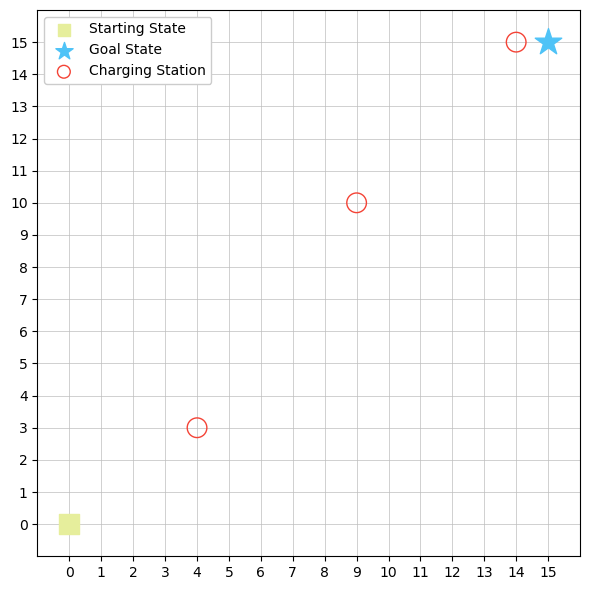

In [16]:
plot_environment(environment, export_path = 'environment.pdf')

### Path

In [17]:
def plot_path(environment: Environment, path: list[Tuple[int, int]], export_path: str = None) -> None:
    '''
    Plots the given path over the environment.
    
    Args:
        environment (Environment): Environment that the agent explored.
        path (list[tuple[int, int]]): Path taken by the agent.
        export_path (str, optional): Path to export the figure to a file.
    '''
    
    # Plot the environment
    fig, ax = plot_environment(environment)
    
    # Plot the path
    ax.plot(*np.array(path).T, c = '#212121', marker = 'o', markersize = 5, zorder = 15, label='Path')
    
    # Re-generate the legend
    ax.legend(loc = 'upper left', markerscale = 0.65, framealpha = 1, frameon = True)
    
    # Adjust layout to fit elements
    plt.tight_layout()
    
    # Save the figure to a file if a path is provided
    if export_path:
        plt.savefig(f'{export_path}')
    
    # Display the plot
    plt.show()

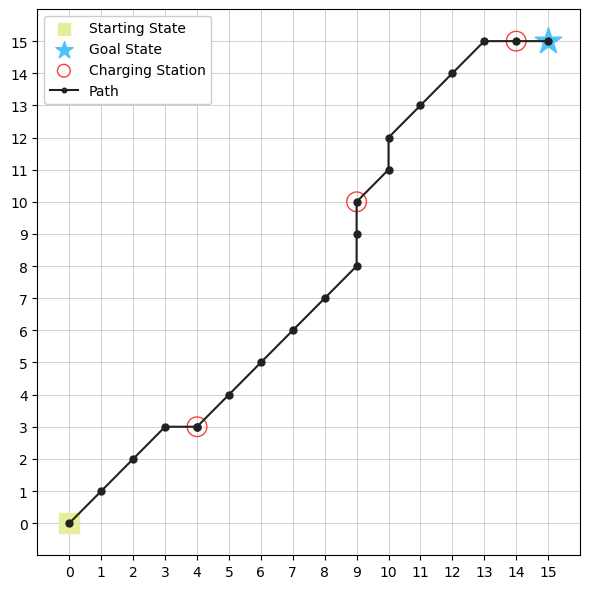

In [18]:
plot_path(environment, path = paths[-1], export_path = 'path.pdf')